In [14]:
import numpy as np

from cnn.utils import plot_sample
from cnn.data import load_binary


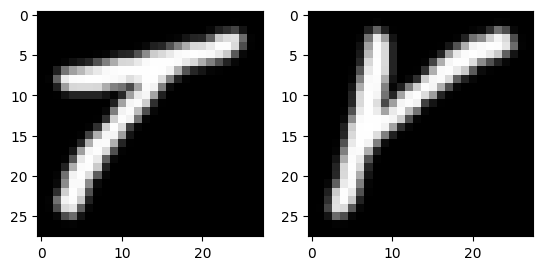

27.0


In [18]:
xtrain, ytrain, xtest, ytest = load_binary()
idx = np.random.randint(xtest.shape[0])
plot_sample(xtest[idx])
print(ytrain[idx])

# why does ipynb need a kernel thats not my venv